## Regression: number of reviews
When you are a restaurant owner you might want a way to predict your number of reviews. Maybe you want to get an insight on what the key features are that drive your number upwards and how you can implement them to be better than your competitors.


In [107]:
from fastai.imports import *
from sklearn.model_selection import  RandomizedSearchCV
import seaborn as sns

original_df = pd.read_csv("tripadvisor_dataset/restaurant_listings.csv")
pd.set_option("display.max_columns", None)


in short, we will do the same preprocessing as we did in sprint 1 and the price classification notebook

*NOTE* in the previous notebook we tried out classification and instead of the city we used the coordinates. Because we want to experiment with different techniques we decided to use the city feature and one-hot encoding on that.

In [108]:
original_df["rank"]=original_df["rank"].str.replace("#","").astype(float)
original_df["general rating"]=original_df["general rating"].map(lambda x: x.split(" ")[0]).astype(float)
original_df["number of reviews"]=original_df["number of reviews"].map(lambda x: x.split(" ")[0].replace(",","")).astype(float)
original_df['city'] = original_df["address"].str.split(', ').str[-1].str.split(" ").str[0]
first_tag=original_df.tags.str.split("|",expand=True)[0].dropna()
ranges=first_tag[first_tag.str.find("$")!=-1]
original_df["price_tag"]=ranges

*NOTE* we can do this preprocessing on the original df because we are not aggregating data, each row is preprocessed individually (we are not using mean/mode/median/...)

now we drop all the features that won't help with our regression

In [109]:
original_df.drop(columns=["restaurant name","address","phone number","website url","menu url","timetable","email address","tags","food rating", "service rating","price range","description","dutch description"], inplace=True)

In [110]:
original_df.columns

Index(['rank', 'general rating', 'number of reviews', 'travelers choice',
       'michelin', 'value rating', 'atmosphere rating', 'cuisines',
       'special diets', 'meals', 'restaurant features', 'id', 'city',
       'price_tag'],
      dtype='object')

now we have learned from our mistakes in the classification notebook. Thats why we will start by looking at the distribution of our target

8.764214470310579

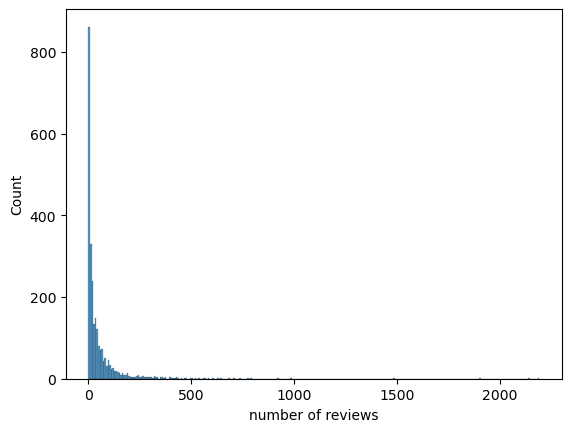

In [111]:
sns.histplot(original_df["number of reviews"])
original_df["number of reviews"].skew()

missing values

In [112]:
original_df["number of reviews"].replace(-1,np.nan).isna().sum()

0

In [113]:
import plotly.express as px
#pip install --upgrade nbformat

px.imshow(original_df[["general rating","rank","number of reviews"]].replace(0,np.nan).replace(-1,np.nan).isna(),title="zero review Heatmap")

this is giving us an indication that the restaurants with 0 reviews do not actually have zero reviews but they are just missing data

to confirm our theory we will look at the reviews dataset


In [114]:
reviews=pd.read_csv("tripadvisor_dataset/reviews.csv")

In [115]:
grouped_df=reviews.groupby("id").count()
grouped_df

,reviewer name,title,date,rating,review
id,,,,,
694642,20,20,20,20,20
694671,94,94,94,94,94
694721,324,324,324,324,324
740592,189,189,189,189,189
740594,53,53,53,53,53
...,...,...,...,...,...
24887062,2,2,2,2,2
24889503,1,1,1,1,1
24897762,1,1,1,1,1


In [116]:
df=original_df[["id","number of reviews"]]
result=df[df["number of reviews"]==0].join(grouped_df, on="id")

In [117]:
result["review"].isna().value_counts()

True     218
False      2
Name: review, dtype: int64

In [118]:
result[~result["review"].isna()]

,id,number of reviews,reviewer name,title,date,rating,review
2414,24066711,0.0,1.0,1.0,1.0,1.0,1.0
2502,24923099,0.0,1.0,1.0,1.0,1.0,1.0


we can actually not conclude that the data in our restaurants listing dataset is wrong, from our "cross check" in the reviews dataset we only have 2 restaurants that are listed to have 0 reviews but actually do have exactly 1 review so we can't throw away that data because we can't proof that the restaurants with zero reviews actually do have reviews

transforming our label because it was severely skewed

number of reviews   -0.077278
dtype: float64

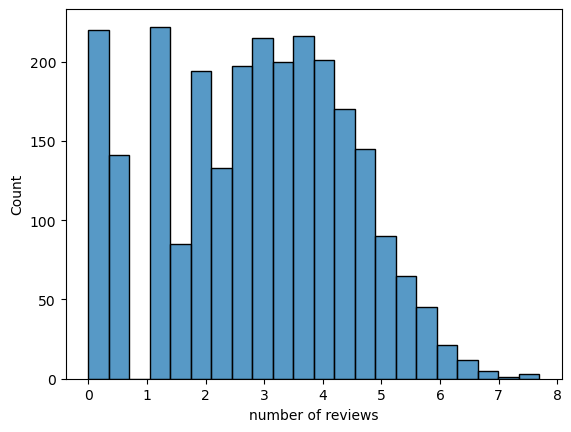

In [119]:
sns.histplot(np.log(original_df["number of reviews"]+1))
pd.DataFrame(np.log(original_df["number of reviews"]+1)).skew()

In [120]:
original_df["lg_target"]=np.log(original_df["number of reviews"]+1)


In [121]:
original_df.drop(columns=["id","number of reviews"],inplace=True)

In [122]:
original_df.columns

Index(['rank', 'general rating', 'travelers choice', 'michelin',
       'value rating', 'atmosphere rating', 'cuisines', 'special diets',
       'meals', 'restaurant features', 'city', 'price_tag', 'lg_target'],
      dtype='object')

labeling our columns for easier processing

In [123]:
mutlihot_col = ['cuisines','special diets',"meals","restaurant features"]


In [124]:
#for easier processing later
for col in mutlihot_col:
    original_df[col]=original_df[col].fillna(col+"_missing").str.replace(" ","").str.split(",")

In [125]:
original_df.head(2)

,rank,general rating,travelers choice,michelin,value rating,atmosphere rating,cuisines,special diets,meals,restaurant features,city,price_tag,lg_target
0,1.0,5.0,True,False,4.5,-1.0,"[Thai, Healthy]","[VegetarianFriendly, VeganOptions, GlutenFreeOptions]","[Dinner, Drinks]","[Reservations, Seating, ServesAlcohol, FreeWifi, TableService, GiftCardsAvailable]",Ghent,$$ - $$$,6.827629
1,1.0,5.0,False,True,4.5,5.0,"[French, Belgian, European]","[VegetarianFriendly, VeganOptions, GlutenFreeOptions]","[Lunch, Dinner]","[FreeWifi, Reservations, OutdoorSeating, Seating, ParkingAvailable, Freeoff-streetparking, WheelchairAccessible, ServesAlcohol, AcceptsAmericanExpress, AcceptsMastercard, AcceptsVisa, AcceptsCreditCards, TableService, HighchairsAvailable, FullBar]",Ninove,$$$$,5.303305


### splitting the data

In [126]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(original_df,test_size=0.2,train_size=0.8,shuffle=True,random_state=42)


Instead of doing everything manually and concatenating everything in the end, we wanted to use a pipeline for cleaner code. We didn't use this in the classification notebook because we did a big part of our preprocessing carefully, looking at the distributions and step by step looking at how our data changes. Now that we already know how to transform everything, we will use the Pipeline functionality. We got some inspiration from [this blogpost](https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a#:~:text=They%20can%20be%20nested%20and,(model)%20at%20the%20end.)

ColumnTransformers are built similarly to Pipelines, except you include a third value in each tuple representing the columns to be transformed in that step.

In [127]:
df_train.head(2)

,rank,general rating,travelers choice,michelin,value rating,atmosphere rating,cuisines,special diets,meals,restaurant features,city,price_tag,lg_target
1684,46.0,3.5,False,False,4.5,-1.0,"[Seafood, Belgian]",[specialdiets_missing],[Dinner],"[Reservations, Seating, TableService]",Dendermonde,$$ - $$$,2.484907
2192,123.0,3.0,False,False,3.0,4.0,"[Belgian, European, Bar, Pub]",[specialdiets_missing],"[Dinner, LateNight]","[Seating, ServesAlcohol, Reservations, TableService]",Aalst,$$ - $$$,4.043051


In [128]:
def transform_df(df):
    df["rank_missing"]=0
    df["atmosphere_missing"]=0
    df["value_missing"]=0
    df["general_missing"]=0
    df["atmosphere rating"]=df["atmosphere rating"].replace(-1,np.nan)
    df["value rating"]=df["value rating"].replace(-1,np.nan)
    df["general rating"]=df["general rating"].replace(-1,np.nan)
    df.loc[df["rank"].isna(),"rank_missing"] = 1
    df.loc[df["atmosphere rating"].isna(),"atmosphere_missing"] = 1
    df.loc[df["value rating"].isna(),"value_rating_missing"] = 1
    df.loc[df["general rating"].isna(),"general_rating_missing"] = 1
    df["lg_rank"]=np.log(df["rank"])
    df.drop(columns=["rank"],inplace=True)
    df.loc[df["price_tag"].isna(),"price_tag"]="$$ - $$$" #fill it with the most common value
    fea_df, gt_df= df.loc[:, df.columns != 'lg_target'],df["lg_target"]
    return fea_df,gt_df

In [129]:
from sklearn.impute import SimpleImputer
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

def impute_numerics(df,istrain):
    if istrain:
        imp_median.fit(df[numeric])
    imputed_data=imp_median.transform(df[numeric])
    df[numeric]=imputed_data
    return df


In [130]:
numeric=["lg_rank","general rating","value rating","atmosphere rating"] #imputing and scaling
mutlihot_col = ['cuisines','special diets',"meals","restaurant features"]
cat_cols = ['travelers choice', 'michelin',"city","price_tag",'rank_missing',
       'atmosphere_missing', 'value_rating_missing', 'general_rating_missing']#one hot encoding
label="lg_target"

In [131]:
df_train,y_train = transform_df(df_train)
df_train=impute_numerics(df_train,True)

In [132]:
df_train

,general rating,travelers choice,michelin,value rating,atmosphere rating,cuisines,special diets,meals,restaurant features,city,price_tag,rank_missing,atmosphere_missing,value_missing,general_missing,value_rating_missing,general_rating_missing,lg_rank
1684,3.5,False,False,4.5,4.0,"[Seafood, Belgian]",[specialdiets_missing],[Dinner],"[Reservations, Seating, TableService]",Dendermonde,$$ - $$$,0,1,0,0,NaN,NaN,3.828641
2192,3.0,False,False,3.0,4.0,"[Belgian, European, Bar, Pub]",[specialdiets_missing],"[Dinner, LateNight]","[Seating, ServesAlcohol, Reservations, TableService]",Aalst,$$ - $$$,0,0,0,0,NaN,NaN,4.812184
361,5.0,False,False,4.5,4.0,"[European, Deli, Portuguese, Cafe, WineBar]","[VegetarianFriendly, VeganOptions]","[Lunch, Drinks, Dinner]","[Takeout, Seating, TableService]",Ghent,$,0,1,0,0,NaN,NaN,5.117994
2025,4.0,False,False,4.0,4.0,"[Steakhouse, Barbecue, Grill]",[specialdiets_missing],[meals_missing],[restaurantfeatures_missing],Hamme,$$ - $$$,0,1,0,0,1.0,NaN,3.367296
1236,5.0,False,False,4.0,4.0,[cuisines_missing],[specialdiets_missing],"[Lunch, Dinner]",[restaurantfeatures_missing],Melle,$$ - $$$,0,1,0,0,1.0,NaN,1.791759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,5.0,False,False,4.0,4.0,[Cafe],[specialdiets_missing],"[Lunch, Dinner]",[GiftCardsAvailable],Ronse,$$ - $$$,0,1,0,0,1.0,NaN,3.332205
1095,3.5,False,False,3.5,4.5,"[Belgian, European, Dutch]",[VegetarianFriendly],"[Lunch, Dinner, Breakfast]","[Reservations, Seating, WheelchairAccessible, TableService, ServesAlcohol]",Dendermonde,$$ - $$$,0,0,0,0,NaN,NaN,3.295837
1130,3.5,False,False,3.5,3.5,"[Belgian, European]",[VegetarianFriendly],"[Lunch, Dinner, Brunch, LateNight]","[Reservations, OutdoorSeating, Seating, HighchairsAvailable, WheelchairAccessible, ServesAlcohol, FullBar, AcceptsCreditCards, TableService]",Ghent,$$ - $$$,0,0,0,0,NaN,NaN,6.084499
1294,3.5,False,False,4.0,4.0,"[Belgian, European]",[specialdiets_missing],[Dinner],"[Reservations, Seating, TableService, OutdoorSeating, WheelchairAccessible, ServesAlcohol]",Hamme,$$ - $$$,0,1,0,0,NaN,NaN,2.772589


so beautifull ☜(ﾟヮﾟ☜)

In [133]:
df_train.columns

Index(['general rating', 'travelers choice', 'michelin', 'value rating',
       'atmosphere rating', 'cuisines', 'special diets', 'meals',
       'restaurant features', 'city', 'price_tag', 'rank_missing',
       'atmosphere_missing', 'value_missing', 'general_missing',
       'value_rating_missing', 'general_rating_missing', 'lg_rank'],
      dtype='object')

There is a problem with using multilabelbiniser on multiple columns at once, that's why we used a custom class, the MultiHotEncoder, that wraps around sklearns MultiLabelBinarizer class and provides us with the functionality to use it in a column transformer

thank you stackoverflow 🙏 [this question](https://stackoverflow.com/questions/59254662/sklearn-columntransformer-with-multilabelbinarizer)

In [134]:
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MultiLabelBinarizer

from help_script import MultiHotEncoder

cols_trans = ColumnTransformer([
    ('mhe',MultiHotEncoder(),mutlihot_col),
    ('ohe', OneHotEncoder(drop='first',handle_unknown="infrequent_if_exist"), cat_cols), 
    # ('imputing',SimpleImputer(strategy="median"),numeric),
    ('scaling',StandardScaler(),numeric)#because scaling and imputing is done in parallel we can't do it in the same transformer
    ])

# col_scale = ColumnTransformer([
#     ('scaling',StandardScaler(),numeric),

#     ],remainder='passthrough')

Note: we had some difficulties with putting everything in a pipeline. Our numerics list has to be imputed and then scaled but in column transformer that is done in parallel. We also can't split them up in 2 transformers because the second transformer gets a numpy array as input and we can't index the columns anymore with strings. That's why we have decided to do the imputing outside of the pipeline.

In [135]:
from sklearn.linear_model import LinearRegression
lr_pipe = Pipeline([
    ('trans', cols_trans),
    ('clf', LinearRegression())
])

In [136]:
lr_pipe

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('mhe', MultiHotEncoder(),
                                                  ['cuisines', 'special diets',
                                                   'meals',
                                                   'restaurant features']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['travelers choice',
                                                   'michelin', 'city',
                                                   'price_tag', 'rank_missing',
                                                   'atmosphere_missing',
                                                   'value_rating_missing',
                                                   'general_rating_missing']),
                                                 ('scaling', StandardScaler(),
                                                  ['lg_rank', 'general rating',
                                                   'value rating',
                                                   'atmosphere rating'])])),
                ('clf', LinearRegression())])

In [137]:
lr_pipe=lr_pipe.fit(df_train,y_train)

our pipeline is finished! now we will apply the same transformation to our test data

In [138]:
df_test,y_test = transform_df(df_test)
df_test=impute_numerics(df_test,False)

In [139]:
lr_pipe

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('mhe', MultiHotEncoder(),
                                                  ['cuisines', 'special diets',
                                                   'meals',
                                                   'restaurant features']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist'),
                                                  ['travelers choice',
                                                   'michelin', 'city',
                                                   'price_tag', 'rank_missing',
                                                   'atmosphere_missing',
                                                   'value_rating_missing',
                                                   'general_rating_missing']),
                                                 ('scaling', StandardScaler(),
                                                  ['lg_rank', 'general rating',
                                                   'value rating',
                                                   'atmosphere rating'])])),
                ('clf', LinearRegression())])

In [140]:
lr_pipe.score(df_test,y_test)

d:\programmas_unif\miniconda\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning:

unknown class(es) ['Assyrian', 'Cajun&Creole', 'Caribbean', 'Catalan', 'Chilean', 'Malaysian', 'Medicinalfoods', 'Norwegian', 'Polish', 'Swedish'] will be ignored

d:\programmas_unif\miniconda\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning:

Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros



0.8669979879767984

now its time to try out different models and see how high of a score we can get


In [141]:
from sklearn.svm import SVR
pipe = Pipeline([
    ('trans', cols_trans),
    ('clf', SVR(C=1.0, epsilon=0.2))
])
svr_pipe=pipe.fit(df_train,y_train)
svr_pipe.score(df_test,y_test)

d:\programmas_unif\miniconda\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning:

unknown class(es) ['Assyrian', 'Cajun&Creole', 'Caribbean', 'Catalan', 'Chilean', 'Malaysian', 'Medicinalfoods', 'Norwegian', 'Polish', 'Swedish'] will be ignored

d:\programmas_unif\miniconda\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning:

Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros



0.9081852580949146

In [142]:
from sklearn.ensemble import RandomForestRegressor
pipe = Pipeline([
    ('trans', cols_trans),
    ('clf', RandomForestRegressor(max_depth=9, random_state=0))
])
rf_pipe=pipe.fit(df_train,y_train)
rf_pipe.score(df_test,y_test)

d:\programmas_unif\miniconda\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning:

unknown class(es) ['Assyrian', 'Cajun&Creole', 'Caribbean', 'Catalan', 'Chilean', 'Malaysian', 'Medicinalfoods', 'Norwegian', 'Polish', 'Swedish'] will be ignored

d:\programmas_unif\miniconda\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning:

Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros



0.9147359194080407

experimenting a bit with the knn regressor and Randmized search

In [143]:
def visualize_performance(search, parameter_set, eval_metric='score'):
    print("Best parameter sets:", search.best_params_, "with the results of ", search.best_score_)
    metric = 'mean_test_%s'%eval_metric
    fig, ax = plt.subplots()
    fig.canvas.draw()
    
    ax.set_xticks(range(len(parameter_set)))
    ax.set_xticklabels(parameter_set)
    ax.plot(range(len(parameter_set)), search.cv_results_[metric])

d:\programmas_unif\miniconda\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning:

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.



Best parameter sets: {'clf__n_neighbors': 6} with the results of  0.8739136224110103


d:\programmas_unif\miniconda\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning:

unknown class(es) ['Assyrian', 'Cajun&Creole', 'Caribbean', 'Catalan', 'Chilean', 'Malaysian', 'Medicinalfoods', 'Norwegian', 'Polish', 'Swedish'] will be ignored

d:\programmas_unif\miniconda\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning:

Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros



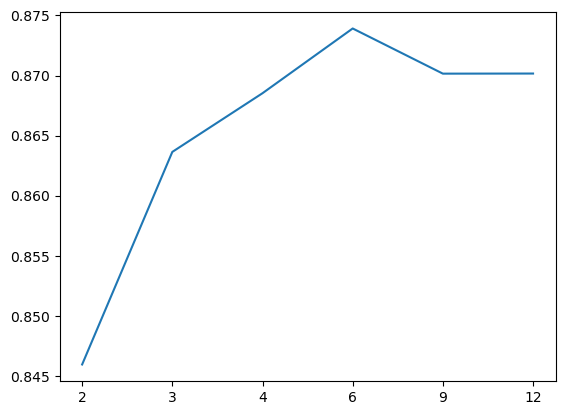

In [144]:
from sklearn.neighbors import KNeighborsRegressor
neighbours=[2,3,4,6,9,12]

param_grid={
    "clf__n_neighbors":neighbours
}


pipe = Pipeline([
    ('trans', cols_trans),
    ('clf', KNeighborsRegressor())
])
knn_search = RandomizedSearchCV(pipe, param_grid, n_jobs=4)

knn_search.fit(df_train,y_train)
knn_search.score(df_test,y_test)
visualize_performance(knn_search, neighbours)

### Featue importances

the random forest regressor is our best model untill now

In [145]:
features=rf_pipe["trans"].get_feature_names_out()
pd.DataFrame(dict(cols=features,imp=rf_pipe["clf"].feature_importances_)).sort_values('imp',ascending=False).head(10)

,cols,imp
306,ohe__value_rating_missing_nan,0.687220
129,mhe__ServesAlcohol,0.086797
307,ohe__general_rating_missing_nan,0.037646
305,ohe__atmosphere_missing_1,0.035382
304,ohe__rank_missing_1,0.034415
140,mhe__restaurantfeatures_missing,0.014247
308,scaling__lg_rank,0.012834
89,mhe__GlutenFreeOptions,0.011877
102,mhe__AcceptsCreditCards,0.004968
128,mhe__Seating,0.004868


these are the 10 most important features, as we expected, the missing values have quite some predictive power (if value rating is missing then the number of reviews is 0)

the restaurant owner could now use this insights to change things up in his restaurant, for example serve Gluten Free options and get a higher number of reviews

### making our own ensemble

for the classification we did an exhaustive search, here we already have decent accuracy on the default parameters, we will now try another trick to improve our performance (experiment like we did with the test time augmentation in the classification notebook).

wE will look if putting multiple models in an ensemlbe will further improve our accuracy (actually the score function displays the coefficient of determination R²)

we will try to combine 2 of our best models, the random forest regressor and the support vetor regressor and get predictions from both of them

In [146]:
from sklearn.metrics import r2_score

models=[rf_pipe,svr_pipe]
all_probs = [t.predict(df_test) for t in models]
avg_probs = np.stack(all_probs).mean(0)

r2_score(y_test, avg_probs)


d:\programmas_unif\miniconda\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning:

unknown class(es) ['Assyrian', 'Cajun&Creole', 'Caribbean', 'Catalan', 'Chilean', 'Malaysian', 'Medicinalfoods', 'Norwegian', 'Polish', 'Swedish'] will be ignored

d:\programmas_unif\miniconda\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning:

Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros

d:\programmas_unif\miniconda\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning:

unknown class(es) ['Assyrian', 'Cajun&Creole', 'Caribbean', 'Catalan', 'Chilean', 'Malaysian', 'Medicinalfoods', 'Norwegian', 'Polish', 'Swedish'] will be ignored

d:\programmas_unif\miniconda\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning:

Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros



0.9188148951509907

it actually worked!! we increased our models performance by putting multiple models together